In [1]:
import json
import matplotlib.pyplot as plt
import baltic as bt
import seaborn as sns
%matplotlib inline
import matplotlib.colors as colors
from copy import deepcopy

In [2]:
tree_file = '../data/titer-model/all-branch-effects/jsons/dengue_all_tree.json'
out_path = '../'

In [3]:
antigenic_tree = bt.loadJSON(tree_file, {'name': 'strain', 'height': 'cTiter'})
genetic_tree = bt.loadJSON(tree_file, {'name': 'strain', 'height': 'xvalue'})


Tree height: 2.472229
Tree length: 6.161171
annotations present

Numbers of objects in tree: 2996 (1426 nodes and 1570 leaves)


Tree height: 0.368260
Tree length: 6.105600
annotations present

Numbers of objects in tree: 2996 (1426 nodes and 1570 leaves)



In [4]:
def antigenically_uniform(node, tree):
        
    node_cTiters = [round(k.traits['cTiter'], 2) for k in tree.traverse_tree(node, include_all=True) if k.traits.has_key('cTiter')]
    node_uniform = len(set(node_cTiters)) == 1
    return node_uniform
#     parent_cTiters = [round(k.traits['cTiter'], 2) for k in tree.traverse_tree(node.parent, include_all=True) if k.traits.has_key('cTiter')]
#     parent_uniform = len(set(parent_cTiters)) == 1
    
#     if node_uniform==True and parent_uniform == False:
#         return True
#     else:
#         return False
                          
def collapse_antigenic_phenotypes(tree):
    tree_copy = deepcopy(tree)
    sorted_branches = sorted(tree_copy.nodes, key = lambda k: k.height, reverse=True)
    
    to_collapse = [ k for k in sorted_branches if antigenically_uniform(k, tree_copy) 
                   and not antigenically_uniform(k.parent, tree_copy)]
    
    for k in to_collapse:
        tree_copy.collapseSubtree(k, k.traits['clade'])

    return tree_copy 

collapsed_antigenic_tree = collapse_antigenic_phenotypes(antigenic_tree)
collapsed_antigenic_tree.drawTree()

In [11]:
def plot_tree(tree, colorby=None, color_callable=None, vmax=None, plot_leaves=True):
    sns.set_style('white')
    plt.yticks(size=0)
    branchWidth=3 ## default branch width
    ll = tree
        
    for k in ll.Objects: ## iterate over objects in tree      
        x=k.x 
        y=k.y 
        yp = k.parent.y

        xp=k.parent.x ## get x position of current object's parent
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x

        c = color_callable(k.traits[colorby]/vmax)

        if plot_leaves:
            if isinstance(k,bt.leaf):# or k.branchType=='leaf': ## if leaf...
                s=10 ## tip size can be fixed

                plt.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
                plt.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
              
        if isinstance(k, bt.clade):
            s = k.width
            plt.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
            plt.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
            plt.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)
        elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
            plt.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=9)
            plt.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)
        else:
            plt.plot([x,x], [y,yp], lw=branchWidth, color=c, ls='-', zorder=9)

In [14]:
collapsed_antigenic_tree.drawUnrooted()
genetic_tree.drawUnrooted()

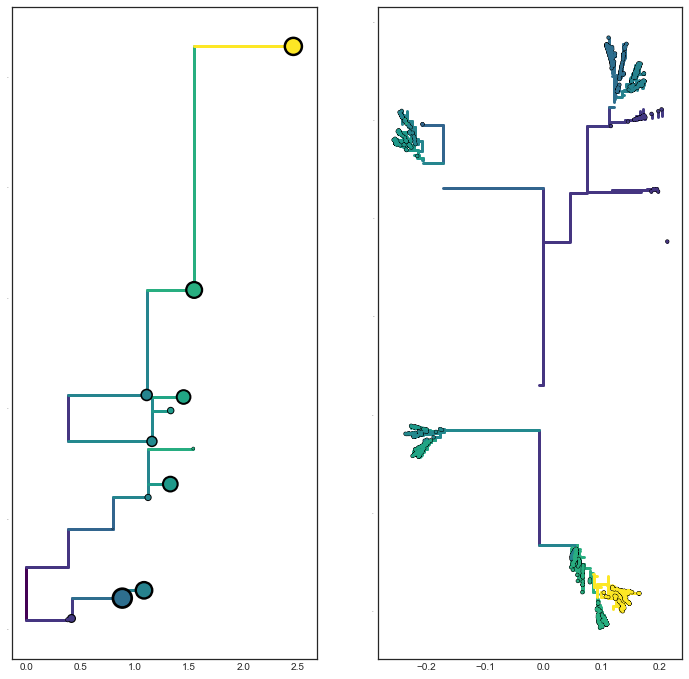

In [15]:
max_cTiter = max([k.traits['cTiter'] for k in antigenic_tree.Objects])
fig, ax = plt.subplots(1,2,figsize=(12,12))
plt.sca(ax[0])
plot_tree(collapsed_antigenic_tree, colorby='cTiter', vmax=max_cTiter, color_callable=plt.get_cmap('viridis'), plot_leaves=False)
plt.sca(ax[1])
plot_tree(genetic_tree, colorby='cTiter', vmax=max_cTiter, color_callable=plt.get_cmap('viridis'))